In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import os

In [64]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing

In [8]:
def convert_to_vect(Q,R,S,T):
    resp=np.empty((0,4))
    end:Boolean= False
    idx_q=0    
    idx_r=0
    idx_s=0
    idx_t=0

    
    while not end:
        try:
            q=Q[idx_q]
            r=R[idx_r]
            s=S[idx_s]
            t=T[idx_t]
        except IndexError:
                end=True
                pass    
       
        arr=np.array([q,r,s,t],dtype=int)
        if not (q <= r and  r <=s and s <=t) :#and q < x_complex and t > x_complex :
            arr=np.array([-1,-1,-1,-1],dtype=int)
            print("no")
            
        else:
            resp=np.vstack((resp,arr))           
            
        if idx_q+1<len(Q):
            idx_q=idx_q+1
        else:
            end=True
        if   idx_r+1<len(R):        
            idx_r=idx_r+1
        else:
            end=True    
        if   idx_s+1<len(S):        
            idx_s=idx_s+1
        else:
            end= True
        if   idx_t+1<len(S):        
            idx_t=idx_t+1
        else:
            end= True    
    return resp

In [4]:
files= os.listdir('./data/processed.old/')

In [5]:
files

['107-113-p000107-2121-11-30-20-03-False.plk',
 '109-129-p000109-2141-10-21-02-00-False.plk',
 '109-148-p000109-2142-08-13-05-59-False.plk',
 '123-165-p000123-2161-10-29-03-01-False.plk',
 '124-169-p000124-2166-01-23-10-43-True.plk',
 '154-206-p000154-2127-12-23-22-02-False.plk',
 '160-214-p000160-2174-11-06-10-12-False.plk',
 '188-251-p000188-2161-12-09-17-50-True.plk',
 '188-251-p000188-2162-01-10-18-53-True.plk',
 '20-18-p000020-2183-04-28-17-47-False.plk',
 '208-272-p000208-2188-05-18-00-06-False.plk',
 '222-290-p000222-2142-06-26-16-08-False.plk',
 '301-382-p000301-2189-11-11-09-04-False.plk',
 '308-394-p000308-2135-09-04-12-57-False.plk',
 '308-394-p000308-2135-09-28-04-22-False.plk',
 '318-403-p000318-2129-06-07-07-15-False.plk',
 '33-32-p000033-2116-12-24-12-35-False.plk',
 '357-460-p000357-2199-12-24-20-47-False.plk',
 '357-460-p000357-2199-12-26-10-43-False.plk',
 '402-511-p000402-2155-01-07-16-11-False.plk',
 '470-595-p000470-2132-04-01-19-56-False.plk',
 '491-616-p000491-21

In [13]:
def to_df_with_col(path):
    df=pd.read_pickle(path)
    df['died']="True" in path
    return df

In [14]:
frames= [to_df_with_col('./data/processed.old/'+f) for f in files]


In [17]:
result = pd.concat(frames)

In [39]:
result.shape

(439771, 4)

In [48]:
result.drop_duplicates(inplace=False).shape

(73298, 4)

In [1]:
73298/439771

0.16667310941376307

In [49]:
result.drop_duplicates(inplace=True)

In [67]:
scaler= preprocessing.StandardScaler().fit(result[['QR','RS','ST']])

C:\Users\AndresM\Anaconda3\envs\hrp\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [69]:
X=scaler.transform(result[['QR','RS','ST']])

C:\Users\AndresM\Anaconda3\envs\hrp\lib\site-packages\ipykernel\__main__.py:1: DataConversionWarning: Data with input dtype int32 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [70]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

In [71]:
labels=db.labels_

In [104]:
metrics.silhouette_score(X,labels, sample_size=10000, random_state=1)

0.2984824820351251

In [72]:
n_noise_ = list(labels).count(-1)

In [73]:
n_noise_

187

In [74]:
a,counts=np.unique(labels, return_counts=True)

In [75]:
a.shape

(69,)

In [76]:
counts

array([  187, 17070,  5584,  2708,  8962,  1402,   825,  9742,  4879,
         680,   317,   472,   467,   179,   103,    23,   512,    12,
        2148,    20,  1060,   456,   303,  1136,   207,  1857,   669,
          39,    16,   278,   196,    34,    71,    17,    46,   134,
          50,   118,   418,  1559,   270,   341,  1061,   126,   256,
          66,   156,   803,  1624,   261,    73,    73,  1364,    19,
         128,   216,    21,    53,    18,    78,    67,   718,    10,
          16,   150,    65,    81,    98,   130], dtype=int64)

In [77]:
import umap

In [80]:
reducer = umap.UMAP()

In [81]:
embedding = reducer.fit_transform(result[['QR','RS','ST']])

C:\Users\AndresM\Anaconda3\envs\hrp\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 27 separate connected components using meta-embedding (experimental)
  n_components
C:\Users\AndresM\Anaconda3\envs\hrp\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,10)

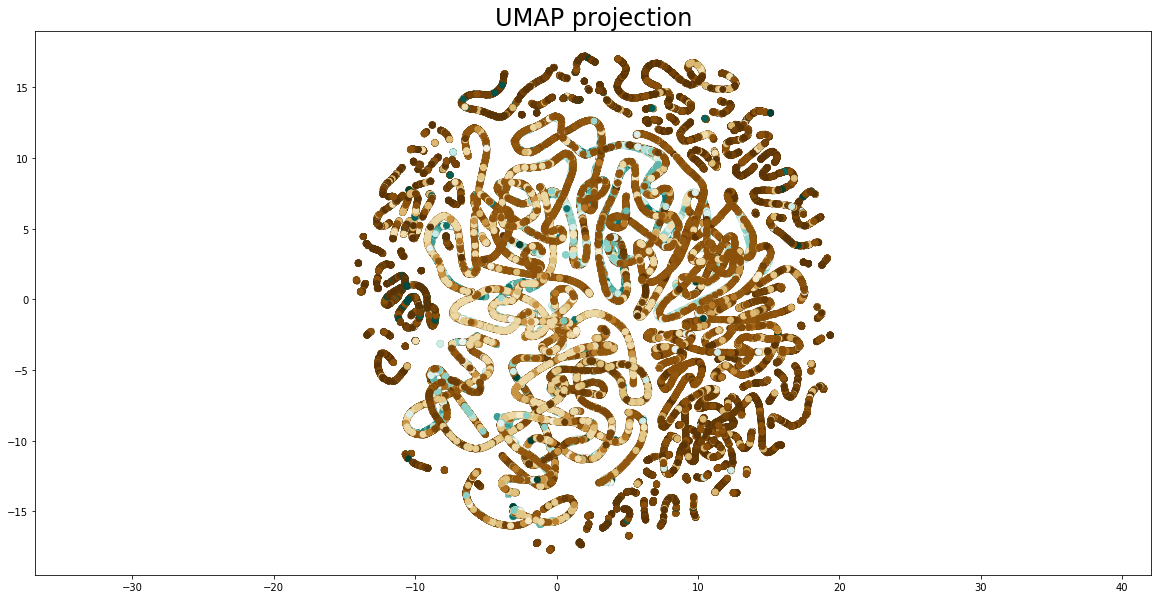

In [96]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette("BrBG", len(a))[x] for x in labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);